# CAR Plates OCR 

## MADE Academy 2020 Competition

In [ ]:
# for colab
! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1E9e4LmjUJxdSgfzfLJgXKOJqtUP6-xYs' -O data.zip
! unzip -qq data.zip

will be placed in the single file you specified.

--2020-06-02 04:19:36--  https://docs.google.com/uc?export=download&id=1E9e4LmjUJxdSgfzfLJgXKOJqtUP6-xYs
Resolving docs.google.com (docs.google.com)... 173.194.76.139, 173.194.76.113, 173.194.76.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.76.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data.zip’

data.zip                [ <=>                ]   3.17K  --.-KB/s    in 0s      

2020-06-02 04:19:36 (32.4 MB/s) - ‘data.zip’ saved [3248]

Loading robots.txt; please ignore errors.
--2020-06-02 04:19:36--  https://docs.google.com/robots.txt
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘data.zip’

data.zip                [ <=>                ]     567  --.-KB/s    in 0s      

2020-06-02 04:19:36 (55.5 MB/s) - ‘data.zip’ saved [567]

--2020-06-02 04:19:36--  h

In [ ]:
import gc
import glob
import json
import os
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tqdm
from matplotlib.path import Path
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw

from IPython.display import clear_output

In [ ]:
torch.__version__, torch.cuda.is_available()

('1.5.0+cu101', True)

### Utils

In [ ]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0.0, 1.0

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print("simplify_contour didnt coverege")
            return None

        k = (lb + ub) / 2.0
        eps = k * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub) / 2.0
        elif len(approx) < n_corners:
            ub = (lb + ub) / 2.0
        else:
            return approx


# Отображаем 4-угольник в прямоугольник
# Спасибо ulebok за идею
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):

    rect = order_points(pts)

    tl, tr, br, bl = pts

    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))

    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))

    dst = np.array(
        [[0, 0], [max_width, 0], [max_width, max_height], [0, max_height]],
        dtype="float32",
    )

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped


def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(
    file, model, device="cuda", verbose=True, thresh=0.0, n_colors=None, id_to_name=None
):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features

    palette = sns.color_palette(None, n_colors)

    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img

    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:, :] = (0, 0, 0)
    for i in range(len(prediction["boxes"])):
        x_min, y_min, x_max, y_max = map(int, prediction["boxes"][i].tolist())
        label = int(prediction["labels"][i].cpu())
        score = float(prediction["scores"][i].cpu())
        mask = prediction["masks"][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]

        if verbose:
            if score > thresh:
                print("Class: {}, Confidence: {}".format(name, score))
        if score > thresh:
            crop_img = image[y_min:y_max, x_min:x_max]
            print("Bounding box:")
            show_image(crop_img, figsize=(10, 2))

            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            #_, contours, _ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)

            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            #                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]

            points = [[x0, y0], [x2, y2], [x1, y1], [x3, y3]]

            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print("Rotated img:")
            crop_mask_img = cv2.resize(
                crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA
            )
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255, 0, 255), 3)
            image = cv2.circle(
                image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1
            )
            image = cv2.circle(
                image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1
            )
            image = cv2.circle(
                image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1
            )
            image = cv2.circle(
                image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1
            )

            image = cv2.rectangle(
                image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2
            )

    show_image(image)
    return prediction


# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[..., ::-1])
    else:
        plt.imshow(image)
    plt.axis("off")
    plt.show()


# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs


def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = "".join([alphabet[c] for c in out])
    return out


def load_json(file):
    with open(file, "r") as f:
        return json.load(f)


# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

Data path

### Config

In [ ]:
TRAIN_SIZE = 0.9
BATCH_SIZE = 4
BATCH_SIZE_OCR = 128
LR = 1e-3
PATIENCE = 3
FACTOR = 0.9
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

In [ ]:
DATA_PATH = "./data/"
DETECTOR_MODEL_PATH = "detector.pt"
OCR_MODEL_PATH = "ocr.pt"

In [ ]:
all_marks = load_json(os.path.join(DATA_PATH, "train.json"))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 1. Находим номера

### a) Модель для детекции

В задании есть данные о 4 точках, которые задают номер. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Поэтому, возьмем maskrcnn. Будем обучать несколько последних слоев. Этого с запасом хватает.

In [ ]:
def get_detector_model():

    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, pretrained_backbone=True, progress=True, num_classes=91,
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor

    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    for param in model.parameters():
        param.requires_grad = False

    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True

    return model

### b) Датасет для детекции

In [ ]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):

        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms

    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        box_coords = item["nums"]
        boxes = []
        labels = []
        masks = []
        
        for box in box_coords:
            points = np.array(box["box"])
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)

            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и маску
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x, y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny, nx)).astype(int)
            masks.append(grid)

        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.marks)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
my_transforms = transforms.Compose([transforms.ToTensor()])

train_dataset = DetectionDataset(
    marks=train_marks, img_folder="data/", transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, img_folder="data/", transforms=my_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn,
)

### c) Обучаем модель для детекции

In [ ]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequentia

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=PATIENCE, factor=FACTOR, verbose=True
)

In [ ]:
model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(
        enumerate(train_loader), leave=False, position=0, total=len(train_loader)
    ):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()

        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f"Loss: {mean_loss:.7f}")
            scheduler.step(mean_loss)
            print_loss = []

  0%|          | 0/5767 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
  0%|          | 20/5767 [00:49<3:30:02,  2.19s/it]

Loss: 2.1672436


  1%|          | 40/5767 [01:34<3:26:14,  2.16s/it]

Loss: 0.7270975


  1%|          | 60/5767 [02:19<3:26:11,  2.17s/it]

Loss: 0.6492583


  1%|▏         | 80/5767 [03:02<3:19:36,  2.11s/it]

Loss: 0.6610298


  2%|▏         | 100/5767 [03:46<3:28:45,  2.21s/it]

Loss: 0.6050418


  2%|▏         | 120/5767 [04:31<3:36:32,  2.30s/it]

Loss: 0.4939851


  2%|▏         | 140/5767 [05:14<3:16:05,  2.09s/it]

Loss: 0.4529887


  3%|▎         | 160/5767 [05:57<3:22:36,  2.17s/it]

Loss: 0.3362361


  3%|▎         | 180/5767 [06:41<3:23:01,  2.18s/it]

Loss: 0.3111920


  3%|▎         | 200/5767 [07:24<3:22:14,  2.18s/it]

Loss: 0.2752160


  4%|▍         | 220/5767 [08:07<3:20:34,  2.17s/it]

Loss: 0.2802988


  4%|▍         | 240/5767 [08:52<3:21:08,  2.18s/it]

Loss: 0.2987106


  5%|▍         | 260/5767 [09:36<3:20:28,  2.18s/it]

Loss: 0.3056470


  5%|▍         | 280/5767 [10:19<3:19:40,  2.18s/it]

Loss: 0.2687943


  5%|▌         | 300/5767 [11:02<3:21:48,  2.21s/it]

Loss: 0.2625947


  6%|▌         | 320/5767 [11:46<3:13:37,  2.13s/it]

Loss: 0.2682722


  6%|▌         | 340/5767 [12:30<3:09:14,  2.09s/it]

Loss: 0.2591636


  6%|▌         | 360/5767 [13:13<3:16:35,  2.18s/it]

Loss: 0.2221325


  7%|▋         | 380/5767 [13:56<3:22:42,  2.26s/it]

Loss: 0.2675495


  7%|▋         | 400/5767 [14:41<3:25:31,  2.30s/it]

Loss: 0.2519715


  7%|▋         | 420/5767 [15:26<3:11:00,  2.14s/it]

Loss: 0.2603052


  8%|▊         | 440/5767 [16:12<3:18:50,  2.24s/it]

Loss: 0.2390838
Epoch    22: reducing learning rate of group 0 to 9.0000e-04.


  8%|▊         | 460/5767 [16:55<3:12:06,  2.17s/it]

Loss: 0.2229840


  8%|▊         | 480/5767 [17:40<3:17:34,  2.24s/it]

Loss: 0.2228890


  9%|▊         | 500/5767 [18:25<3:21:41,  2.30s/it]

Loss: 0.2094411


  9%|▉         | 520/5767 [19:10<3:17:16,  2.26s/it]

Loss: 0.2093193


  9%|▉         | 540/5767 [19:53<3:08:00,  2.16s/it]

Loss: 0.2088831


 10%|▉         | 560/5767 [20:38<3:04:26,  2.13s/it]

Loss: 0.2037546


 10%|█         | 580/5767 [21:22<3:02:07,  2.11s/it]

Loss: 0.2112347


 10%|█         | 600/5767 [22:07<3:13:28,  2.25s/it]

Loss: 0.2161611


 11%|█         | 620/5767 [22:50<3:02:23,  2.13s/it]

Loss: 0.2169900


 11%|█         | 640/5767 [23:35<3:17:05,  2.31s/it]

Loss: 0.2106839
Epoch    32: reducing learning rate of group 0 to 8.1000e-04.


 11%|█▏        | 660/5767 [24:20<3:08:20,  2.21s/it]

Loss: 0.2316801


 12%|█▏        | 680/5767 [25:04<3:18:01,  2.34s/it]

Loss: 0.2304363


 12%|█▏        | 700/5767 [25:48<3:05:30,  2.20s/it]

Loss: 0.2334914


 12%|█▏        | 720/5767 [26:33<3:17:15,  2.34s/it]

Loss: 0.2245737
Epoch    36: reducing learning rate of group 0 to 7.2900e-04.


 13%|█▎        | 740/5767 [27:17<3:05:54,  2.22s/it]

Loss: 0.2152880


 13%|█▎        | 760/5767 [28:01<3:10:58,  2.29s/it]

Loss: 0.1905701


 14%|█▎        | 780/5767 [28:44<3:01:33,  2.18s/it]

Loss: 0.2372438


 14%|█▍        | 800/5767 [29:28<3:01:54,  2.20s/it]

Loss: 0.2057294


 14%|█▍        | 820/5767 [30:11<2:59:32,  2.18s/it]

Loss: 0.1917129


 15%|█▍        | 840/5767 [30:56<3:05:03,  2.25s/it]

Loss: 0.2008102
Epoch    42: reducing learning rate of group 0 to 6.5610e-04.


 15%|█▍        | 860/5767 [31:41<3:07:13,  2.29s/it]

Loss: 0.2312405


 15%|█▌        | 880/5767 [32:25<3:00:41,  2.22s/it]

Loss: 0.2321180


 16%|█▌        | 900/5767 [33:09<2:53:26,  2.14s/it]

Loss: 0.1791584


 16%|█▌        | 920/5767 [33:53<3:07:59,  2.33s/it]

Loss: 0.1982154


 16%|█▋        | 940/5767 [34:39<3:03:25,  2.28s/it]

Loss: 0.1973755


 17%|█▋        | 960/5767 [35:22<3:03:54,  2.30s/it]

Loss: 0.2043902


 17%|█▋        | 980/5767 [36:05<2:52:34,  2.16s/it]

Loss: 0.2134529
Epoch    49: reducing learning rate of group 0 to 5.9049e-04.


 17%|█▋        | 1000/5767 [36:49<2:52:42,  2.17s/it]

Loss: 0.1920511


 18%|█▊        | 1020/5767 [37:32<2:47:08,  2.11s/it]

Loss: 0.1809225


 18%|█▊        | 1040/5767 [38:18<3:04:00,  2.34s/it]

Loss: 0.2046881


 18%|█▊        | 1060/5767 [39:01<2:46:11,  2.12s/it]

Loss: 0.2148414
Epoch    53: reducing learning rate of group 0 to 5.3144e-04.


 19%|█▊        | 1080/5767 [39:46<2:58:31,  2.29s/it]

Loss: 0.1932754


 19%|█▉        | 1100/5767 [40:31<2:57:28,  2.28s/it]

Loss: 0.1896092


 19%|█▉        | 1120/5767 [41:16<2:59:19,  2.32s/it]

Loss: 0.1854702


 20%|█▉        | 1140/5767 [41:59<2:48:14,  2.18s/it]

Loss: 0.2004316
Epoch    57: reducing learning rate of group 0 to 4.7830e-04.


 20%|██        | 1160/5767 [42:44<2:46:44,  2.17s/it]

Loss: 0.1845815


 20%|██        | 1180/5767 [43:30<2:55:26,  2.29s/it]

Loss: 0.1916493


 21%|██        | 1200/5767 [44:15<2:44:28,  2.16s/it]

Loss: 0.1879502


 21%|██        | 1220/5767 [45:03<2:56:00,  2.32s/it]

Loss: 0.1874828
Epoch    61: reducing learning rate of group 0 to 4.3047e-04.


 22%|██▏       | 1240/5767 [45:49<2:43:24,  2.17s/it]

Loss: 0.1652723


 22%|██▏       | 1260/5767 [46:35<2:50:09,  2.27s/it]

Loss: 0.1667147


 22%|██▏       | 1280/5767 [47:21<2:57:10,  2.37s/it]

Loss: 0.1947688


 23%|██▎       | 1300/5767 [48:07<2:54:23,  2.34s/it]

Loss: 0.1919012


 23%|██▎       | 1320/5767 [48:51<2:47:20,  2.26s/it]

Loss: 0.1812687
Epoch    66: reducing learning rate of group 0 to 3.8742e-04.


 23%|██▎       | 1340/5767 [49:37<2:46:10,  2.25s/it]

Loss: 0.1893634


 24%|██▎       | 1360/5767 [50:24<2:57:11,  2.41s/it]

Loss: 0.1881467


 24%|██▍       | 1380/5767 [51:10<2:54:50,  2.39s/it]

Loss: 0.2025020


 24%|██▍       | 1400/5767 [51:55<2:42:48,  2.24s/it]

Loss: 0.1884047
Epoch    70: reducing learning rate of group 0 to 3.4868e-04.


 25%|██▍       | 1420/5767 [52:41<2:50:02,  2.35s/it]

Loss: 0.1795136


 25%|██▍       | 1440/5767 [53:27<2:53:03,  2.40s/it]

Loss: 0.1928519


 25%|██▌       | 1460/5767 [54:13<2:43:50,  2.28s/it]

Loss: 0.1879548


 26%|██▌       | 1480/5767 [55:01<2:42:49,  2.28s/it]

Loss: 0.1863424
Epoch    74: reducing learning rate of group 0 to 3.1381e-04.


 26%|██▌       | 1500/5767 [55:47<2:47:57,  2.36s/it]

Loss: 0.1615258


 26%|██▋       | 1520/5767 [56:33<2:51:33,  2.42s/it]

Loss: 0.1780713


 27%|██▋       | 1540/5767 [57:17<2:39:11,  2.26s/it]

Loss: 0.1642576


 27%|██▋       | 1560/5767 [58:03<2:50:45,  2.44s/it]

Loss: 0.1704137


 27%|██▋       | 1580/5767 [58:49<2:39:55,  2.29s/it]

Loss: 0.1649996
Epoch    79: reducing learning rate of group 0 to 2.8243e-04.


 28%|██▊       | 1600/5767 [59:35<2:34:55,  2.23s/it]

Loss: 0.1670541


 28%|██▊       | 1620/5767 [1:00:21<2:37:01,  2.27s/it]

Loss: 0.1601251


 28%|██▊       | 1640/5767 [1:01:06<2:31:00,  2.20s/it]

Loss: 0.1652225


 29%|██▉       | 1660/5767 [1:01:54<2:48:27,  2.46s/it]

Loss: 0.1790336


 29%|██▉       | 1680/5767 [1:02:39<2:35:03,  2.28s/it]

Loss: 0.1759009


 29%|██▉       | 1700/5767 [1:03:24<2:28:44,  2.19s/it]

Loss: 0.1785895
Epoch    85: reducing learning rate of group 0 to 2.5419e-04.


 30%|██▉       | 1720/5767 [1:04:09<2:29:01,  2.21s/it]

Loss: 0.1736605


 30%|███       | 1740/5767 [1:04:54<2:36:19,  2.33s/it]

Loss: 0.1733700


 31%|███       | 1760/5767 [1:05:39<2:23:10,  2.14s/it]

Loss: 0.1902966


 31%|███       | 1780/5767 [1:06:24<2:26:10,  2.20s/it]

Loss: 0.1724705
Epoch    89: reducing learning rate of group 0 to 2.2877e-04.


 31%|███       | 1800/5767 [1:07:12<2:33:56,  2.33s/it]

Loss: 0.1622841


 32%|███▏      | 1820/5767 [1:07:58<2:35:09,  2.36s/it]

Loss: 0.1743871


 32%|███▏      | 1840/5767 [1:08:43<2:22:53,  2.18s/it]

Loss: 0.1759846


 32%|███▏      | 1860/5767 [1:09:30<2:27:57,  2.27s/it]

Loss: 0.1826071
Epoch    93: reducing learning rate of group 0 to 2.0589e-04.


 33%|███▎      | 1880/5767 [1:10:17<2:26:35,  2.26s/it]

Loss: 0.1794830


 33%|███▎      | 1900/5767 [1:11:04<2:30:54,  2.34s/it]

Loss: 0.1811380


 33%|███▎      | 1920/5767 [1:11:49<2:22:05,  2.22s/it]

Loss: 0.1524002


 34%|███▎      | 1940/5767 [1:12:36<2:17:41,  2.16s/it]

Loss: 0.1747845


 34%|███▍      | 1960/5767 [1:13:22<2:23:50,  2.27s/it]

Loss: 0.1884816


 34%|███▍      | 1980/5767 [1:14:06<2:24:23,  2.29s/it]

Loss: 0.1989719


 35%|███▍      | 2000/5767 [1:14:52<2:22:56,  2.28s/it]

Loss: 0.1786292
Epoch   100: reducing learning rate of group 0 to 1.8530e-04.


 35%|███▌      | 2020/5767 [1:15:38<2:20:15,  2.25s/it]

Loss: 0.1737034


 35%|███▌      | 2040/5767 [1:16:24<2:24:31,  2.33s/it]

Loss: 0.1719123


 36%|███▌      | 2060/5767 [1:17:09<2:13:42,  2.16s/it]

Loss: 0.1518744


 36%|███▌      | 2080/5767 [1:17:54<2:23:47,  2.34s/it]

Loss: 0.1859935


 36%|███▋      | 2100/5767 [1:18:41<2:32:07,  2.49s/it]

Loss: 0.1557955


 37%|███▋      | 2120/5767 [1:19:27<2:19:45,  2.30s/it]

Loss: 0.1568669


 37%|███▋      | 2140/5767 [1:20:13<2:21:56,  2.35s/it]

Loss: 0.1698657
Epoch   107: reducing learning rate of group 0 to 1.6677e-04.


 37%|███▋      | 2160/5767 [1:20:59<2:17:18,  2.28s/it]

Loss: 0.1748472


 38%|███▊      | 2180/5767 [1:21:47<2:22:19,  2.38s/it]

Loss: 0.1614184


 38%|███▊      | 2200/5767 [1:22:32<2:16:58,  2.30s/it]

Loss: 0.1734053


 38%|███▊      | 2220/5767 [1:23:19<2:19:14,  2.36s/it]

Loss: 0.1817253
Epoch   111: reducing learning rate of group 0 to 1.5009e-04.


 39%|███▉      | 2240/5767 [1:24:05<2:21:03,  2.40s/it]

Loss: 0.1641876


 39%|███▉      | 2260/5767 [1:24:50<2:12:09,  2.26s/it]

Loss: 0.1681266


 40%|███▉      | 2280/5767 [1:25:35<2:15:20,  2.33s/it]

Loss: 0.1791862


 40%|███▉      | 2300/5767 [1:26:21<2:10:08,  2.25s/it]

Loss: 0.1767860
Epoch   115: reducing learning rate of group 0 to 1.3509e-04.


 40%|████      | 2320/5767 [1:27:07<2:16:48,  2.38s/it]

Loss: 0.1750710


 41%|████      | 2340/5767 [1:27:53<2:10:49,  2.29s/it]

Loss: 0.1662255


 41%|████      | 2360/5767 [1:28:38<2:08:19,  2.26s/it]

Loss: 0.1594991


 41%|████▏     | 2380/5767 [1:29:23<2:09:20,  2.29s/it]

Loss: 0.1771148
Epoch   119: reducing learning rate of group 0 to 1.2158e-04.


 42%|████▏     | 2400/5767 [1:30:08<2:06:49,  2.26s/it]

Loss: 0.1773638


 42%|████▏     | 2420/5767 [1:30:53<2:05:53,  2.26s/it]

Loss: 0.1729939


 42%|████▏     | 2440/5767 [1:31:38<1:59:35,  2.16s/it]

Loss: 0.1648300


 43%|████▎     | 2460/5767 [1:32:25<2:07:46,  2.32s/it]

Loss: 0.1592556
Epoch   123: reducing learning rate of group 0 to 1.0942e-04.


 43%|████▎     | 2480/5767 [1:33:11<2:08:37,  2.35s/it]

Loss: 0.1816253


 43%|████▎     | 2500/5767 [1:33:56<1:58:15,  2.17s/it]

Loss: 0.1994750


 44%|████▎     | 2520/5767 [1:34:42<2:05:59,  2.33s/it]

Loss: 0.1603165


 44%|████▍     | 2540/5767 [1:35:29<2:06:13,  2.35s/it]

Loss: 0.1693336
Epoch   127: reducing learning rate of group 0 to 9.8477e-05.


 44%|████▍     | 2560/5767 [1:36:15<2:08:30,  2.40s/it]

Loss: 0.1584828


 45%|████▍     | 2580/5767 [1:37:00<2:04:20,  2.34s/it]

Loss: 0.1941732


 45%|████▌     | 2600/5767 [1:37:46<1:58:07,  2.24s/it]

Loss: 0.1609244


 45%|████▌     | 2620/5767 [1:38:33<2:03:26,  2.35s/it]

Loss: 0.1767076
Epoch   131: reducing learning rate of group 0 to 8.8629e-05.


 46%|████▌     | 2640/5767 [1:39:18<1:59:36,  2.29s/it]

Loss: 0.1711615


 46%|████▌     | 2660/5767 [1:40:03<1:55:29,  2.23s/it]

Loss: 0.1995765


 46%|████▋     | 2680/5767 [1:40:48<1:55:39,  2.25s/it]

Loss: 0.1688920


 47%|████▋     | 2700/5767 [1:41:33<1:55:54,  2.27s/it]

Loss: 0.1575999
Epoch   135: reducing learning rate of group 0 to 7.9766e-05.


 47%|████▋     | 2720/5767 [1:42:19<1:53:29,  2.23s/it]

Loss: 0.1670859


 48%|████▊     | 2740/5767 [1:43:05<1:59:24,  2.37s/it]

Loss: 0.1758632


 48%|████▊     | 2760/5767 [1:43:50<1:54:16,  2.28s/it]

Loss: 0.1649884


 48%|████▊     | 2780/5767 [1:44:35<1:51:52,  2.25s/it]

Loss: 0.1613821
Epoch   139: reducing learning rate of group 0 to 7.1790e-05.


 49%|████▊     | 2800/5767 [1:45:22<1:57:07,  2.37s/it]

Loss: 0.1817351


 49%|████▉     | 2820/5767 [1:46:07<1:49:32,  2.23s/it]

Loss: 0.1673661


 49%|████▉     | 2840/5767 [1:46:55<1:56:40,  2.39s/it]

Loss: 0.1765586


 50%|████▉     | 2860/5767 [1:47:41<1:52:47,  2.33s/it]

Loss: 0.1479016


 50%|████▉     | 2880/5767 [1:48:27<1:48:03,  2.25s/it]

Loss: 0.1556223


 50%|█████     | 2900/5767 [1:49:13<1:49:08,  2.28s/it]

Loss: 0.1779475


 51%|█████     | 2920/5767 [1:49:59<1:50:09,  2.32s/it]

Loss: 0.1599234


 51%|█████     | 2940/5767 [1:50:45<1:49:39,  2.33s/it]

Loss: 0.1657956
Epoch   147: reducing learning rate of group 0 to 6.4611e-05.


 51%|█████▏    | 2960/5767 [1:51:31<1:49:04,  2.33s/it]

Loss: 0.1908750


 52%|█████▏    | 2980/5767 [1:52:16<1:50:05,  2.37s/it]

Loss: 0.1690960


 52%|█████▏    | 3000/5767 [1:53:02<1:44:49,  2.27s/it]

Loss: 0.1585207


 52%|█████▏    | 3020/5767 [1:53:48<1:48:57,  2.38s/it]

Loss: 0.1575364
Epoch   151: reducing learning rate of group 0 to 5.8150e-05.


 53%|█████▎    | 3040/5767 [1:54:34<1:45:10,  2.31s/it]

Loss: 0.1515841


 53%|█████▎    | 3060/5767 [1:55:21<1:46:34,  2.36s/it]

Loss: 0.1540878


 53%|█████▎    | 3080/5767 [1:56:08<1:45:53,  2.36s/it]

Loss: 0.1632255


 54%|█████▍    | 3100/5767 [1:56:55<1:49:36,  2.47s/it]

Loss: 0.1620602
Epoch   155: reducing learning rate of group 0 to 5.2335e-05.


 54%|█████▍    | 3120/5767 [1:57:41<1:42:26,  2.32s/it]

Loss: 0.1584187


 54%|█████▍    | 3140/5767 [1:58:26<1:37:44,  2.23s/it]

Loss: 0.1540552


 55%|█████▍    | 3160/5767 [1:59:11<1:37:06,  2.23s/it]

Loss: 0.1615582


 55%|█████▌    | 3180/5767 [1:59:56<1:34:52,  2.20s/it]

Loss: 0.1697165
Epoch   159: reducing learning rate of group 0 to 4.7101e-05.


 55%|█████▌    | 3200/5767 [2:00:42<1:42:44,  2.40s/it]

Loss: 0.1501466


 56%|█████▌    | 3220/5767 [2:01:28<1:39:21,  2.34s/it]

Loss: 0.1531124


 56%|█████▌    | 3240/5767 [2:02:16<1:46:42,  2.53s/it]

Loss: 0.1636788


 57%|█████▋    | 3260/5767 [2:03:02<1:39:52,  2.39s/it]

Loss: 0.1581991
Epoch   163: reducing learning rate of group 0 to 4.2391e-05.


 57%|█████▋    | 3280/5767 [2:03:48<1:35:59,  2.32s/it]

Loss: 0.1371236


 57%|█████▋    | 3300/5767 [2:04:34<1:32:16,  2.24s/it]

Loss: 0.1574611


 58%|█████▊    | 3320/5767 [2:05:20<1:36:53,  2.38s/it]

Loss: 0.1484766


 58%|█████▊    | 3340/5767 [2:06:06<1:31:18,  2.26s/it]

Loss: 0.1603562


 58%|█████▊    | 3360/5767 [2:06:51<1:26:14,  2.15s/it]

Loss: 0.1466815
Epoch   168: reducing learning rate of group 0 to 3.8152e-05.


 59%|█████▊    | 3380/5767 [2:07:39<1:35:00,  2.39s/it]

Loss: 0.1618691


 59%|█████▉    | 3400/5767 [2:08:25<1:30:25,  2.29s/it]

Loss: 0.1591270


 59%|█████▉    | 3420/5767 [2:09:12<1:30:38,  2.32s/it]

Loss: 0.1544487


 60%|█████▉    | 3440/5767 [2:10:00<1:29:47,  2.32s/it]

Loss: 0.1588555
Epoch   172: reducing learning rate of group 0 to 3.4337e-05.


 60%|█████▉    | 3460/5767 [2:10:46<1:29:07,  2.32s/it]

Loss: 0.1604749


 60%|██████    | 3480/5767 [2:11:31<1:25:58,  2.26s/it]

Loss: 0.1496326


 61%|██████    | 3500/5767 [2:12:16<1:23:45,  2.22s/it]

Loss: 0.1697932


 61%|██████    | 3520/5767 [2:13:02<1:26:49,  2.32s/it]

Loss: 0.1566944
Epoch   176: reducing learning rate of group 0 to 3.0903e-05.


 61%|██████▏   | 3540/5767 [2:13:49<1:29:07,  2.40s/it]

Loss: 0.1484683


 62%|██████▏   | 3560/5767 [2:14:36<1:25:09,  2.32s/it]

Loss: 0.1494230


 62%|██████▏   | 3580/5767 [2:15:22<1:20:36,  2.21s/it]

Loss: 0.1886655


 62%|██████▏   | 3600/5767 [2:16:07<1:22:31,  2.28s/it]

Loss: 0.1513784
Epoch   180: reducing learning rate of group 0 to 2.7813e-05.


 63%|██████▎   | 3620/5767 [2:16:52<1:24:02,  2.35s/it]

Loss: 0.1522668


 63%|██████▎   | 3640/5767 [2:17:37<1:15:42,  2.14s/it]

Loss: 0.1442384


 63%|██████▎   | 3660/5767 [2:18:22<1:20:01,  2.28s/it]

Loss: 0.1645515


 64%|██████▍   | 3680/5767 [2:19:07<1:16:46,  2.21s/it]

Loss: 0.1477326
Epoch   184: reducing learning rate of group 0 to 2.5032e-05.


 64%|██████▍   | 3700/5767 [2:19:52<1:17:20,  2.25s/it]

Loss: 0.1552109


 65%|██████▍   | 3720/5767 [2:20:40<1:19:50,  2.34s/it]

Loss: 0.1703080


 65%|██████▍   | 3740/5767 [2:21:27<1:20:45,  2.39s/it]

Loss: 0.1504926


 65%|██████▌   | 3760/5767 [2:22:13<1:17:55,  2.33s/it]

Loss: 0.1432638
Epoch   188: reducing learning rate of group 0 to 2.2528e-05.


 66%|██████▌   | 3780/5767 [2:22:59<1:17:50,  2.35s/it]

Loss: 0.1657499


 66%|██████▌   | 3800/5767 [2:23:45<1:16:10,  2.32s/it]

Loss: 0.1742505


 66%|██████▌   | 3820/5767 [2:24:31<1:20:40,  2.49s/it]

Loss: 0.1607061


 67%|██████▋   | 3840/5767 [2:25:17<1:14:00,  2.30s/it]

Loss: 0.1730252
Epoch   192: reducing learning rate of group 0 to 2.0276e-05.


 67%|██████▋   | 3860/5767 [2:26:03<1:13:13,  2.30s/it]

Loss: 0.1470095


 67%|██████▋   | 3880/5767 [2:26:49<1:11:35,  2.28s/it]

Loss: 0.1546141


 68%|██████▊   | 3900/5767 [2:27:36<1:13:28,  2.36s/it]

Loss: 0.1464088


 68%|██████▊   | 3920/5767 [2:28:22<1:08:58,  2.24s/it]

Loss: 0.1618753
Epoch   196: reducing learning rate of group 0 to 1.8248e-05.


 68%|██████▊   | 3940/5767 [2:29:10<1:16:35,  2.52s/it]

Loss: 0.1511697


 69%|██████▊   | 3960/5767 [2:29:56<1:08:03,  2.26s/it]

Loss: 0.1533437


 69%|██████▉   | 3980/5767 [2:30:42<1:11:30,  2.40s/it]

Loss: 0.1562091


 69%|██████▉   | 4000/5767 [2:31:29<1:12:33,  2.46s/it]

Loss: 0.1484241
Epoch   200: reducing learning rate of group 0 to 1.6423e-05.


 70%|██████▉   | 4020/5767 [2:32:14<1:05:33,  2.25s/it]

Loss: 0.1519140


 70%|███████   | 4040/5767 [2:33:00<1:07:18,  2.34s/it]

Loss: 0.1568299


 70%|███████   | 4060/5767 [2:33:47<1:06:17,  2.33s/it]

Loss: 0.1572831


 71%|███████   | 4080/5767 [2:34:33<1:06:23,  2.36s/it]

Loss: 0.1739520
Epoch   204: reducing learning rate of group 0 to 1.4781e-05.


 71%|███████   | 4100/5767 [2:35:19<1:06:09,  2.38s/it]

Loss: 0.1847689


 71%|███████▏  | 4120/5767 [2:36:05<1:04:56,  2.37s/it]

Loss: 0.1633047


 72%|███████▏  | 4140/5767 [2:36:50<1:03:12,  2.33s/it]

Loss: 0.1730100


 72%|███████▏  | 4160/5767 [2:37:37<1:05:28,  2.44s/it]

Loss: 0.1799119
Epoch   208: reducing learning rate of group 0 to 1.3303e-05.


 72%|███████▏  | 4180/5767 [2:38:23<1:01:55,  2.34s/it]

Loss: 0.1557697


 73%|███████▎  | 4200/5767 [2:39:09<1:03:48,  2.44s/it]

Loss: 0.1512964


 73%|███████▎  | 4220/5767 [2:39:56<1:01:45,  2.39s/it]

Loss: 0.1421786


 74%|███████▎  | 4240/5767 [2:40:42<57:08,  2.24s/it]

Loss: 0.1590254
Epoch   212: reducing learning rate of group 0 to 1.1973e-05.


 74%|███████▍  | 4260/5767 [2:41:28<58:32,  2.33s/it]

Loss: 0.1613352


 74%|███████▍  | 4280/5767 [2:42:15<59:56,  2.42s/it]

Loss: 0.1473116


 75%|███████▍  | 4300/5767 [2:42:59<53:10,  2.17s/it]

Loss: 0.1650119


 75%|███████▍  | 4320/5767 [2:43:46<55:43,  2.31s/it]

Loss: 0.1536227
Epoch   216: reducing learning rate of group 0 to 1.0775e-05.


 75%|███████▌  | 4340/5767 [2:44:33<56:23,  2.37s/it]

Loss: 0.1754436


 76%|███████▌  | 4360/5767 [2:45:19<53:10,  2.27s/it]

Loss: 0.1432225


 76%|███████▌  | 4380/5767 [2:46:05<50:07,  2.17s/it]

Loss: 0.1571789


 76%|███████▋  | 4400/5767 [2:46:52<54:46,  2.40s/it]

Loss: 0.1437129
Epoch   220: reducing learning rate of group 0 to 9.6977e-06.


 77%|███████▋  | 4420/5767 [2:47:40<55:35,  2.48s/it]

Loss: 0.1628909


 77%|███████▋  | 4440/5767 [2:48:25<50:02,  2.26s/it]

Loss: 0.1491701


 77%|███████▋  | 4460/5767 [2:49:10<49:01,  2.25s/it]

Loss: 0.1473267


 78%|███████▊  | 4480/5767 [2:49:56<47:18,  2.21s/it]

Loss: 0.1434482
Epoch   224: reducing learning rate of group 0 to 8.7280e-06.


 78%|███████▊  | 4500/5767 [2:50:41<48:24,  2.29s/it]

Loss: 0.1615133


 78%|███████▊  | 4520/5767 [2:51:28<49:53,  2.40s/it]

Loss: 0.1512022


 79%|███████▊  | 4540/5767 [2:52:15<45:42,  2.24s/it]

Loss: 0.1614015


 79%|███████▉  | 4560/5767 [2:53:01<45:26,  2.26s/it]

Loss: 0.1429018
Epoch   228: reducing learning rate of group 0 to 7.8552e-06.


 79%|███████▉  | 4580/5767 [2:53:48<45:22,  2.29s/it]

Loss: 0.1503527


 80%|███████▉  | 4600/5767 [2:54:34<46:23,  2.39s/it]

Loss: 0.1464232


 80%|████████  | 4620/5767 [2:55:21<43:30,  2.28s/it]

Loss: 0.1625353


 80%|████████  | 4640/5767 [2:56:06<41:42,  2.22s/it]

Loss: 0.1699402
Epoch   232: reducing learning rate of group 0 to 7.0697e-06.


 81%|████████  | 4660/5767 [2:56:51<41:27,  2.25s/it]

Loss: 0.1600291


 81%|████████  | 4680/5767 [2:57:37<42:12,  2.33s/it]

Loss: 0.1738555


 81%|████████▏ | 4700/5767 [2:58:23<40:44,  2.29s/it]

Loss: 0.1518095


 82%|████████▏ | 4720/5767 [2:59:10<40:49,  2.34s/it]

Loss: 0.1649383
Epoch   236: reducing learning rate of group 0 to 6.3627e-06.


 82%|████████▏ | 4740/5767 [2:59:57<38:18,  2.24s/it]

Loss: 0.1656882


 83%|████████▎ | 4760/5767 [3:00:42<39:00,  2.32s/it]

Loss: 0.1569603


 83%|████████▎ | 4780/5767 [3:01:28<37:21,  2.27s/it]

Loss: 0.1531398


 83%|████████▎ | 4800/5767 [3:02:14<36:10,  2.24s/it]

Loss: 0.1742440
Epoch   240: reducing learning rate of group 0 to 5.7264e-06.


 84%|████████▎ | 4820/5767 [3:02:59<35:38,  2.26s/it]

Loss: 0.1606817


 84%|████████▍ | 4840/5767 [3:03:46<35:57,  2.33s/it]

Loss: 0.1704100


 84%|████████▍ | 4860/5767 [3:04:32<36:25,  2.41s/it]

Loss: 0.1723625


 85%|████████▍ | 4880/5767 [3:05:19<34:52,  2.36s/it]

Loss: 0.1592235
Epoch   244: reducing learning rate of group 0 to 5.1538e-06.


 85%|████████▍ | 4900/5767 [3:06:05<32:45,  2.27s/it]

Loss: 0.1412158


 85%|████████▌ | 4920/5767 [3:06:50<32:17,  2.29s/it]

Loss: 0.1540726


 86%|████████▌ | 4940/5767 [3:07:36<33:06,  2.40s/it]

Loss: 0.1639757


 86%|████████▌ | 4960/5767 [3:08:22<30:30,  2.27s/it]

Loss: 0.1532338
Epoch   248: reducing learning rate of group 0 to 4.6384e-06.


 86%|████████▋ | 4980/5767 [3:09:09<31:18,  2.39s/it]

Loss: 0.1530668


 87%|████████▋ | 5000/5767 [3:09:56<29:46,  2.33s/it]

Loss: 0.1569557


 87%|████████▋ | 5020/5767 [3:10:41<28:29,  2.29s/it]

Loss: 0.1523399


 87%|████████▋ | 5040/5767 [3:11:27<27:43,  2.29s/it]

Loss: 0.1608916
Epoch   252: reducing learning rate of group 0 to 4.1746e-06.


 88%|████████▊ | 5060/5767 [3:12:13<27:44,  2.35s/it]

Loss: 0.1422660


 88%|████████▊ | 5080/5767 [3:12:59<26:55,  2.35s/it]

Loss: 0.1708652


 88%|████████▊ | 5100/5767 [3:13:46<25:09,  2.26s/it]

Loss: 0.1503152


 89%|████████▉ | 5120/5767 [3:14:32<24:02,  2.23s/it]

Loss: 0.1524527
Epoch   256: reducing learning rate of group 0 to 3.7571e-06.


 89%|████████▉ | 5140/5767 [3:15:17<23:47,  2.28s/it]

Loss: 0.1512507


 89%|████████▉ | 5160/5767 [3:16:03<24:26,  2.42s/it]

Loss: 0.1479785


 90%|████████▉ | 5180/5767 [3:16:49<22:53,  2.34s/it]

Loss: 0.1481693


 90%|█████████ | 5200/5767 [3:17:35<21:34,  2.28s/it]

Loss: 0.1627865
Epoch   260: reducing learning rate of group 0 to 3.3814e-06.


 91%|█████████ | 5220/5767 [3:18:21<21:19,  2.34s/it]

Loss: 0.1536321


 91%|█████████ | 5240/5767 [3:19:07<19:19,  2.20s/it]

Loss: 0.1438776


 91%|█████████ | 5260/5767 [3:19:54<20:39,  2.44s/it]

Loss: 0.1663928


 92%|█████████▏| 5280/5767 [3:20:42<19:05,  2.35s/it]

Loss: 0.1576411
Epoch   264: reducing learning rate of group 0 to 3.0433e-06.


 92%|█████████▏| 5300/5767 [3:21:29<17:39,  2.27s/it]

Loss: 0.1673776


 92%|█████████▏| 5320/5767 [3:22:16<17:04,  2.29s/it]

Loss: 0.1493132


 93%|█████████▎| 5340/5767 [3:23:02<16:39,  2.34s/it]

Loss: 0.1707418


 93%|█████████▎| 5360/5767 [3:23:48<15:37,  2.30s/it]

Loss: 0.1555333
Epoch   268: reducing learning rate of group 0 to 2.7389e-06.


 93%|█████████▎| 5380/5767 [3:24:35<15:00,  2.33s/it]

Loss: 0.1688657


 94%|█████████▎| 5400/5767 [3:25:20<14:15,  2.33s/it]

Loss: 0.1575731


 94%|█████████▍| 5420/5767 [3:26:06<12:48,  2.21s/it]

Loss: 0.1585745


 94%|█████████▍| 5440/5767 [3:26:52<13:01,  2.39s/it]

Loss: 0.1566169
Epoch   272: reducing learning rate of group 0 to 2.4650e-06.


 95%|█████████▍| 5460/5767 [3:27:38<11:47,  2.30s/it]

Loss: 0.1498480


 95%|█████████▌| 5480/5767 [3:28:25<10:39,  2.23s/it]

Loss: 0.1492636


 95%|█████████▌| 5500/5767 [3:29:11<09:57,  2.24s/it]

Loss: 0.1409509


 96%|█████████▌| 5520/5767 [3:29:56<09:22,  2.28s/it]

Loss: 0.1594252
Epoch   276: reducing learning rate of group 0 to 2.2185e-06.


 96%|█████████▌| 5540/5767 [3:30:44<08:37,  2.28s/it]

Loss: 0.1688417


 96%|█████████▋| 5560/5767 [3:31:30<07:51,  2.28s/it]

Loss: 0.1528071


 97%|█████████▋| 5580/5767 [3:32:14<06:43,  2.16s/it]

Loss: 0.1511966


 97%|█████████▋| 5600/5767 [3:33:00<06:32,  2.35s/it]

Loss: 0.1647846
Epoch   280: reducing learning rate of group 0 to 1.9967e-06.


 97%|█████████▋| 5620/5767 [3:33:46<05:33,  2.27s/it]

Loss: 0.1653854


 98%|█████████▊| 5640/5767 [3:34:32<04:40,  2.21s/it]

Loss: 0.1488704


 98%|█████████▊| 5660/5767 [3:35:17<03:53,  2.18s/it]

Loss: 0.1507664


 98%|█████████▊| 5680/5767 [3:36:03<03:27,  2.38s/it]

Loss: 0.1714765
Epoch   284: reducing learning rate of group 0 to 1.7970e-06.


 99%|█████████▉| 5700/5767 [3:36:49<02:31,  2.26s/it]

Loss: 0.1670908


 99%|█████████▉| 5720/5767 [3:37:35<01:46,  2.27s/it]

Loss: 0.1547894


100%|█████████▉| 5740/5767 [3:38:19<00:59,  2.22s/it]

Loss: 0.1732231


100%|█████████▉| 5760/5767 [3:39:07<00:16,  2.38s/it]

Loss: 0.1584597
Epoch   288: reducing learning rate of group 0 to 1.6173e-06.


In [ ]:
# torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [ ]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Class: plate, Confidence: 0.9992259740829468
Bounding box:


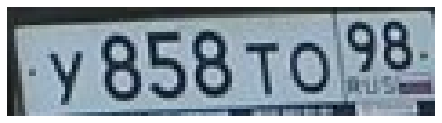

Rotated img:


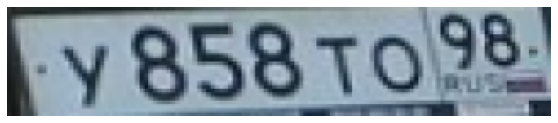

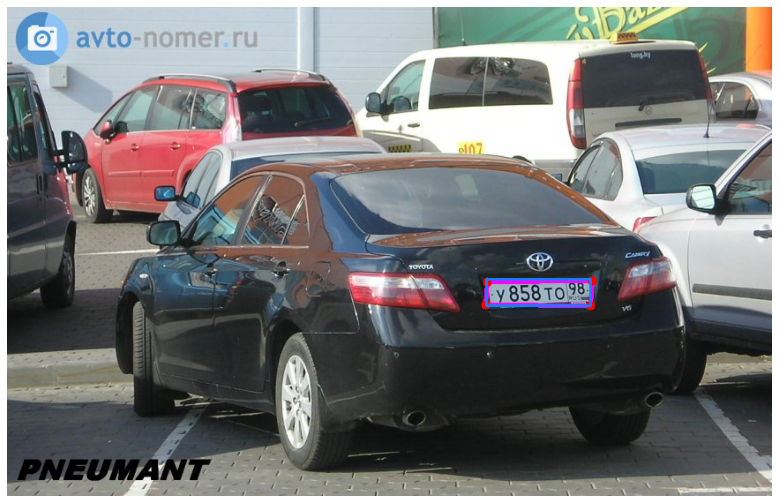

{'boxes': tensor([[543.5192, 309.4579, 661.6700, 339.6424]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
 'scores': tensor([0.9992], device='cuda:0')}

In [ ]:
visualize_prediction_plate(
    np.random.choice(test_images), 
    model, 
    id_to_name={1: 'plate'}, 
    thresh=0.95,
    )

### d) Предсказываем bounding box-ы и маску. 

- Маску превращаем в 4-угольный полигон. Сохраняем предсказания в json
- Если маска не приближается 4-угольником (редко такое бывает, бинарный поиск по гиперпараметру не работает), то просто записываем координаты bounding box 

In [ ]:
preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:      
            # В разных версиях opencv этот метод возвращает разное число параметров
            # Оставил для версии colab
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

  0%|          | 0/3188 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
 34%|███▍      | 1090/3188 [06:45<12:56,  2.70it/s]

simplify_contour didnt coverege


 36%|███▌      | 1136/3188 [07:02<11:57,  2.86it/s]

simplify_contour didnt coverege


 79%|███████▉  | 2522/3188 [15:45<04:06,  2.70it/s]

simplify_contour didnt coverege


 89%|████████▉ | 2831/3188 [17:43<02:27,  2.42it/s]

simplify_contour didnt coverege


# 2. Распознаем номера

### a) Датасет для распознавания номеров

Из особенностей - на каждый номер мы генерируем bounding box + вырезаем по точкам и превращаем в прямоугольник наш 4-угольник по данным точкам. Т.е. 2 картинки на номер.

In [ ]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

0

### b) Модель для распознования текста номера

Взял RCNN из семинара

In [ ]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

### c) Обучаем модель для распознавания текста номера

In [ ]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
optimizer = torch.optim.AdamW(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, factor=FACTOR, verbose=True)

In [ ]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(3):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  5%|▌         | 20/377 [00:58<17:23,  2.92s/it]

Loss: 0.1030464


 11%|█         | 40/377 [01:53<15:20,  2.73s/it]

Loss: 0.1077664


 16%|█▌        | 60/377 [02:48<14:31,  2.75s/it]

Loss: 0.1029040


 21%|██        | 80/377 [03:43<13:01,  2.63s/it]

Loss: 0.1096435


 27%|██▋       | 100/377 [04:36<12:00,  2.60s/it]

Loss: 0.1023336


 32%|███▏      | 120/377 [05:31<11:36,  2.71s/it]

Loss: 0.1114322


 37%|███▋      | 140/377 [06:27<10:46,  2.73s/it]

Loss: 0.0985845


 42%|████▏     | 160/377 [07:23<09:52,  2.73s/it]

Loss: 0.1032252


 48%|████▊     | 180/377 [08:17<09:04,  2.77s/it]

Loss: 0.1020981


 53%|█████▎    | 200/377 [09:13<07:54,  2.68s/it]

Loss: 0.1153978


 58%|█████▊    | 220/377 [10:08<07:18,  2.79s/it]

Loss: 0.0971814


 64%|██████▎   | 240/377 [11:03<06:29,  2.84s/it]

Loss: 0.1102101


 69%|██████▉   | 260/377 [11:56<05:02,  2.59s/it]

Loss: 0.1070297


 74%|███████▍  | 280/377 [12:50<04:20,  2.69s/it]

Loss: 0.1065156


 80%|███████▉  | 300/377 [13:44<03:25,  2.67s/it]

Loss: 0.1114868
Epoch    15: reducing learning rate of group 0 to 2.7000e-04.


 85%|████████▍ | 320/377 [14:39<02:33,  2.69s/it]

Loss: 0.1139357


 90%|█████████ | 340/377 [15:34<01:43,  2.79s/it]

Loss: 0.1110578


 95%|█████████▌| 360/377 [16:28<00:44,  2.62s/it]

Loss: 0.1016827


  0%|          | 0/377 [00:00<?, ?it/s]

376 0.10624035378666076


  5%|▌         | 20/377 [00:53<15:55,  2.68s/it]

Loss: 0.0936847


 11%|█         | 40/377 [01:48<15:20,  2.73s/it]

Loss: 0.1060728


 16%|█▌        | 60/377 [02:42<13:59,  2.65s/it]

Loss: 0.0895102


 21%|██        | 80/377 [03:39<14:43,  2.98s/it]

Loss: 0.1025705


 27%|██▋       | 100/377 [04:33<12:40,  2.75s/it]

Loss: 0.0845660


 32%|███▏      | 120/377 [05:27<11:46,  2.75s/it]

Loss: 0.1020546


 37%|███▋      | 140/377 [06:21<10:22,  2.62s/it]

Loss: 0.0869206


 42%|████▏     | 160/377 [07:15<09:22,  2.59s/it]

Loss: 0.1016912


 48%|████▊     | 180/377 [08:10<09:11,  2.80s/it]

Loss: 0.1025820
Epoch    27: reducing learning rate of group 0 to 2.4300e-04.


 53%|█████▎    | 200/377 [09:05<08:05,  2.75s/it]

Loss: 0.0903245


 58%|█████▊    | 220/377 [09:58<07:14,  2.77s/it]

Loss: 0.0958974


 64%|██████▎   | 240/377 [10:51<06:04,  2.66s/it]

Loss: 0.1000604


 69%|██████▉   | 260/377 [11:45<05:21,  2.75s/it]

Loss: 0.0849274
Epoch    31: reducing learning rate of group 0 to 2.1870e-04.


 74%|███████▍  | 280/377 [12:40<04:29,  2.78s/it]

Loss: 0.0930130


 80%|███████▉  | 300/377 [13:33<03:28,  2.71s/it]

Loss: 0.0932149


 85%|████████▍ | 320/377 [14:25<02:32,  2.67s/it]

Loss: 0.0986409


 90%|█████████ | 340/377 [15:21<01:43,  2.81s/it]

Loss: 0.1028254
Epoch    35: reducing learning rate of group 0 to 1.9683e-04.


 95%|█████████▌| 360/377 [16:15<00:45,  2.69s/it]

Loss: 0.1043169


  0%|          | 0/377 [00:00<?, ?it/s]

376 0.09631775243489432


  5%|▌         | 20/377 [00:54<16:27,  2.77s/it]

Loss: 0.0963705


 11%|█         | 40/377 [01:48<15:33,  2.77s/it]

Loss: 0.0948780


 16%|█▌        | 60/377 [02:44<14:40,  2.78s/it]

Loss: 0.0868922
Epoch    39: reducing learning rate of group 0 to 1.7715e-04.


 21%|██        | 80/377 [03:39<13:45,  2.78s/it]

Loss: 0.0837131


 27%|██▋       | 100/377 [04:33<12:59,  2.82s/it]

Loss: 0.0840624


 32%|███▏      | 120/377 [05:28<11:19,  2.64s/it]

Loss: 0.1026746


 37%|███▋      | 140/377 [06:23<11:06,  2.81s/it]

Loss: 0.0795848


 42%|████▏     | 160/377 [07:18<09:40,  2.68s/it]

Loss: 0.0838862


 48%|████▊     | 180/377 [08:12<08:43,  2.66s/it]

Loss: 0.0907937


 53%|█████▎    | 200/377 [09:06<07:52,  2.67s/it]

Loss: 0.0827438


 58%|█████▊    | 220/377 [09:59<06:59,  2.67s/it]

Loss: 0.0868116
Epoch    47: reducing learning rate of group 0 to 1.5943e-04.


 64%|██████▎   | 240/377 [10:54<06:02,  2.65s/it]

Loss: 0.0889742


 69%|██████▉   | 260/377 [11:46<04:57,  2.55s/it]

Loss: 0.0871220


 74%|███████▍  | 280/377 [12:40<04:19,  2.67s/it]

Loss: 0.0845157


 80%|███████▉  | 300/377 [13:34<03:27,  2.70s/it]

Loss: 0.0785567


 85%|████████▍ | 320/377 [14:29<02:36,  2.74s/it]

Loss: 0.0861482


 90%|█████████ | 340/377 [15:22<01:40,  2.73s/it]

Loss: 0.0932472


 95%|█████████▌| 360/377 [16:16<00:44,  2.64s/it]

Loss: 0.0967276


376 0.08875962884340742


In [ ]:
# torch.save(crnn.state_dict(), OCR_MODEL_PATH)

### d) Наконец, делаем предсказания

In [ ]:
!ls data

submission.csv	test  test.json  train	train.json


In [ ]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)

filename = f"submission_{np.mean(epoch_losses):.4f}.csv"
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv(f"{filename}", index=False)

In [ ]:
!ls

adc.json  data.zip     submission_0.0888.csv
data	  sample_data  submission_0.1259.csv


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
uploaded = drive.CreateFile({'title': f'{filename}'})

In [ ]:
uploaded.SetContentFile(f'{filename}')
uploaded.Upload()